## A) Paths & imports

In [2]:
import os, json, random, math
from ast import literal_eval
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ndcg_score, average_precision_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import joblib

BASE = r"C:\Users\Nicho\Desktop\Literature\Code\recommender\Data"
RECIPES_CSV = os.path.join(BASE, "recipes", "PP_recipes.csv")
RAW_CSV     = os.path.join(BASE, "recipes", "RAW_recipes.csv")
TRN_CSV     = os.path.join(BASE, "recipes", "interactions_train.csv")
VAL_CSV     = os.path.join(BASE, "recipes", "interactions_validation.csv")
TST_CSV     = os.path.join(BASE, "recipes", "interactions_test.csv")

ART_DIR = os.path.join(os.getcwd(), "artifacts_ui")
os.makedirs(ART_DIR, exist_ok=True)

MODEL_PTH = os.path.join(os.getcwd(), "hybrid_model.pth")
U2I_JSON  = os.path.join(ART_DIR, "user2idx.json")
R2I_JSON  = os.path.join(ART_DIR, "recipe2idx.json")
RID_NPY   = os.path.join(ART_DIR, "recipe_ids_order.npy")
CM_NPY    = os.path.join(ART_DIR, "content_matrix.npy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## B) Load datasets

In [3]:
def _safe_lit(x):
    if isinstance(x, str):
        try: return literal_eval(x)
        except Exception: return x
    return x

train = pd.read_csv(TRN_CSV)
val   = pd.read_csv(VAL_CSV)
test  = pd.read_csv(TST_CSV)
interactions_all = pd.concat([train, val, test], ignore_index=True)

recipes = pd.read_csv(RECIPES_CSV)
for col in ['ingredient_tokens','ingredient_ids','name_tokens']:
    if col in recipes.columns:
        recipes[col] = recipes[col].apply(_safe_lit)

raw_recipes = pd.read_csv(RAW_CSV) if os.path.isfile(RAW_CSV) else None
print("Interactions:", interactions_all.shape)
print("Recipes:", recipes.shape, "| RAW available:", raw_recipes is not None)


Interactions: (718379, 6)
Recipes: (178265, 8) | RAW available: True


## C) Long-tail filter

In [4]:
user_counts   = Counter(interactions_all['user_id'])
recipe_counts = Counter(interactions_all['recipe_id'])

df_f = interactions_all[
    (interactions_all['user_id'].map(user_counts.get) >= 5) &
    (interactions_all['recipe_id'].map(recipe_counts.get) >= 5)
].copy()

print(f"After filter: {len(df_f)} interactions (users={df_f['user_id'].nunique()}, recipes={df_f['recipe_id'].nunique()})")


After filter: 453157 interactions (users=16356, recipes=34356)


## D) Index maps

In [5]:
unique_users   = df_f['user_id'].unique()
unique_recipes = df_f['recipe_id'].unique()

user2idx   = {uid:i for i,uid in enumerate(unique_users)}
recipe2idx = {rid:i for i,rid in enumerate(unique_recipes)}

df_f['user_idx']   = df_f['user_id'].map(user2idx)
df_f['recipe_idx'] = df_f['recipe_id'].map(recipe2idx)

print("Users:", len(user2idx), "| Recipes:", len(recipe2idx))


Users: 16356 | Recipes: 34356


## E) Build content text

In [6]:
def _flatten_token_field(x):
    out=[]
    if isinstance(x, list):
        for g in x:
            out.extend(g if isinstance(g, list) else [g])
    return [str(t) for t in out]

recipes_filtered = recipes[recipes['id'].isin(recipe2idx)].copy().reset_index(drop=True)

ing_txt  = recipes_filtered['ingredient_tokens'].apply(_flatten_token_field).apply(lambda xs: " ".join(xs) if xs else "")
name_txt = recipes_filtered['name_tokens'].apply(_flatten_token_field).apply(lambda xs: " ".join(xs) if xs else "")
recipes_filtered['content_text'] = (ing_txt + " " + name_txt).str.strip()

print("Example content_text:", recipes_filtered['content_text'].iloc[0][:120], "…")


Example content_text: 2911 1019 249 6878 1353 6953 15341 3261 2056 857 643 1631 20480 40480 37229 2911 1019 249 6878 6878 2839 1781 40481 …


## F) TF-IDF matrix

In [7]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2)
content_matrix = vectorizer.fit_transform(recipes_filtered['content_text']).astype(np.float32).toarray()
print("TF-IDF shape:", content_matrix.shape)


TF-IDF shape: (34356, 5027)


## G) Align & split

In [8]:
final_recipes = recipes_filtered['id'].tolist()
recipe2idx = {rid:i for i,rid in enumerate(final_recipes)}  # overwrite to TF-IDF order

df_f = df_f[df_f['recipe_id'].isin(recipe2idx)].copy()
df_f['recipe_idx'] = df_f['recipe_id'].map(recipe2idx)

train_df, temp_df = train_test_split(df_f, test_size=0.3, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Split — train={len(train_df)}  val={len(val_df)}  test={len(test_df)}")


Split — train=317209  val=67974  test=67974


## H) Datasets & loaders

In [9]:
class RecipeDataset(Dataset):
    def __init__(self, df):
        self.u = df['user_idx'].values
        self.r = df['recipe_idx'].values
        self.y = df['rating'].values
        self.X = content_matrix[self.r]
    def __len__(self): return len(self.u)
    def __getitem__(self, i):
        return (torch.tensor(self.u[i], dtype=torch.long),
                torch.tensor(self.r[i], dtype=torch.long),
                torch.tensor(self.X[i], dtype=torch.float32),
                torch.tensor(self.y[i], dtype=torch.float32))

train_loader = DataLoader(RecipeDataset(train_df), batch_size=512, shuffle=True)
val_loader   = DataLoader(RecipeDataset(val_df),   batch_size=512)
test_loader  = DataLoader(RecipeDataset(test_df),  batch_size=512)

print("Dataloaders ready.")


Dataloaders ready.


## I) Hybrid model

In [10]:
class HybridRecModel(nn.Module):
    def __init__(self, n_users, n_items, content_dim, emb=96, p_drop=0.15):
        super().__init__()
        self.user_embed   = nn.Embedding(n_users, emb)
        self.item_embed   = nn.Embedding(n_items, emb)
        self.content_fc   = nn.Linear(content_dim, emb)
        self.drop         = nn.Dropout(p_drop)
        self.out          = nn.Linear(emb*3, 1)
    def forward(self, u_idx, i_idx, c_vec):
        u = self.user_embed(u_idx)
        v = self.item_embed(i_idx)
        c = torch.relu(self.content_fc(c_vec))
        x = torch.cat([u,v,c], dim=1)
        x = self.drop(x)
        return self.out(x).reshape(-1)

model = HybridRecModel(len(user2idx), len(recipe2idx), content_matrix.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()


## J) Simple BPR sampler

In [11]:
pos_by_user = defaultdict(set)
for u,r in zip(df_f['user_idx'].values, df_f['recipe_idx'].values):
    pos_by_user[int(u)].add(int(r))

def sample_neg_for(user_idx, n_items, forbidden: set):
    while True:
        j = int(np.random.randint(0, n_items))
        if j not in forbidden: return j


## K) Train (MSE + λ·BPR)

In [12]:
LAMBDA_BPR = 0.3
EPOCHS = 20
best_val = float("inf"); best = None
hist = {"train_total":[], "train_mse":[], "train_bpr":[], "val_mse":[]}

for ep in range(1, EPOCHS+1):
    model.train()
    s_total = s_mse = s_bpr = 0.0
    for u, r, X, y in tqdm(train_loader, leave=False):
        u, r, X, y = u.to(device), r.to(device), X.to(device), y.to(device)
        pred = model(u, r, X)
        mse  = criterion(pred, y)

        # BPR
        neg = [sample_neg_for(int(ui), len(recipe2idx), pos_by_user[int(ui)]) for ui in u.cpu().numpy()]
        neg = torch.tensor(neg, dtype=torch.long, device=device)
        Xn  = torch.tensor(content_matrix[neg.cpu().numpy()], dtype=torch.float32, device=device)
        s_pos = model(u, r, X)
        s_neg = model(u, neg, Xn)
        bpr   = torch.relu(1.0 - (s_pos - s_neg)).mean()

        loss = mse + LAMBDA_BPR * bpr
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        bs = u.size(0); s_total += loss.item()*bs; s_mse += mse.item()*bs; s_bpr += bpr.item()*bs

    tr_total = s_total/len(train_loader.dataset)
    tr_mse   = s_mse/len(train_loader.dataset)
    tr_bpr   = s_bpr/len(train_loader.dataset)

    model.eval(); v_sum = 0.0
    with torch.no_grad():
        for u, r, X, y in val_loader:
            u, r, X, y = u.to(device), r.to(device), X.to(device), y.to(device)
            v_sum += criterion(model(u, r, X), y).item()*u.size(0)
    v_mse = v_sum/len(val_loader.dataset)

    hist["train_total"].append(tr_total); hist["train_mse"].append(tr_mse); hist["train_bpr"].append(tr_bpr); hist["val_mse"].append(v_mse)
    if v_mse < best_val:
        best_val = v_mse; best = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"New best @ epoch {ep} (val MSE={best_val:.4f})")
    print(f"Epoch {ep}/{EPOCHS} | Train total={tr_total:.4f} mse={tr_mse:.4f} bpr={tr_bpr:.4f} | Val MSE={v_mse:.4f}")

if best is not None:
    model.load_state_dict(best)
    print(f"Restored best (val MSE={best_val:.4f})")


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 1 (val MSE=0.8852)
Epoch 1/20 | Train total=3.2536 mse=2.9536 bpr=0.9998 | Val MSE=0.8852


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 2 (val MSE=0.8368)
Epoch 2/20 | Train total=1.2417 mse=0.9498 bpr=0.9730 | Val MSE=0.8368


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 3 (val MSE=0.8120)
Epoch 3/20 | Train total=1.1953 mse=0.9072 bpr=0.9603 | Val MSE=0.8120


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 4 (val MSE=0.7990)
Epoch 4/20 | Train total=1.1604 mse=0.8759 bpr=0.9483 | Val MSE=0.7990


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 5 (val MSE=0.7933)
Epoch 5/20 | Train total=1.1258 mse=0.8461 bpr=0.9322 | Val MSE=0.7933


  0%|          | 0/620 [00:00<?, ?it/s]

New best @ epoch 6 (val MSE=0.7864)
Epoch 6/20 | Train total=1.0973 mse=0.8220 bpr=0.9176 | Val MSE=0.7864


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 7/20 | Train total=1.0726 mse=0.8014 bpr=0.9039 | Val MSE=0.7881


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 8/20 | Train total=1.0536 mse=0.7858 bpr=0.8929 | Val MSE=0.7881


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 9/20 | Train total=1.0372 mse=0.7714 bpr=0.8859 | Val MSE=0.7928


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 10/20 | Train total=1.0235 mse=0.7597 bpr=0.8794 | Val MSE=0.8001


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 11/20 | Train total=1.0126 mse=0.7504 bpr=0.8740 | Val MSE=0.7981


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 12/20 | Train total=1.0005 mse=0.7394 bpr=0.8703 | Val MSE=0.8065


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 13/20 | Train total=0.9914 mse=0.7317 bpr=0.8656 | Val MSE=0.8025


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 14/20 | Train total=0.9835 mse=0.7239 bpr=0.8655 | Val MSE=0.8045


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 15/20 | Train total=0.9767 mse=0.7182 bpr=0.8616 | Val MSE=0.8069


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 16/20 | Train total=0.9704 mse=0.7121 bpr=0.8608 | Val MSE=0.8143


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 17/20 | Train total=0.9659 mse=0.7079 bpr=0.8599 | Val MSE=0.8129


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 18/20 | Train total=0.9607 mse=0.7032 bpr=0.8581 | Val MSE=0.8164


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 19/20 | Train total=0.9562 mse=0.6992 bpr=0.8568 | Val MSE=0.8133


  0%|          | 0/620 [00:00<?, ?it/s]

Epoch 20/20 | Train total=0.9506 mse=0.6935 bpr=0.8570 | Val MSE=0.8162
Restored best (val MSE=0.7864)


## L) Save model & artifacts

In [13]:
import json, numpy as np, os, torch

# Reuse paths defined earlier (MODEL_PTH, ART_DIR, U2I_JSON, R2I_JSON, RID_NPY, CM_NPY)
os.makedirs(ART_DIR, exist_ok=True)

torch.save(model.state_dict(), MODEL_PTH)
with open(U2I_JSON, "w", encoding="utf-8") as f: json.dump({int(k): int(v) for k, v in user2idx.items()}, f)
with open(R2I_JSON, "w", encoding="utf-8") as f: json.dump({int(k): int(v) for k, v in recipe2idx.items()}, f)
np.save(RID_NPY, np.array(final_recipes, dtype=np.int64))
np.save(CM_NPY,  content_matrix.astype(np.float32))
# Persist the fitted TF-IDF vectorizer for future item encodes
joblib.dump(vectorizer, os.path.join(ART_DIR, "tfidf_vectorizer.joblib"))
print("Saved:", "tfidf_vectorizer.joblib")

print("Saved:", MODEL_PTH)
print("Artifacts:", os.path.basename(U2I_JSON), os.path.basename(R2I_JSON),
      os.path.basename(RID_NPY), os.path.basename(CM_NPY))


Saved: tfidf_vectorizer.joblib
Saved: C:\Users\Nicho\Desktop\Literature\Code\recommender\hybrid_model.pth
Artifacts: user2idx.json recipe2idx.json recipe_ids_order.npy content_matrix.npy


## M) Evaluation helper (Top-K)

In [14]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import ndcg_score, average_precision_score

def evaluate_topk(model, dataloader, top_k=5):
    model.eval()
    upred, truth = defaultdict(list), defaultdict(list)

    with torch.no_grad():
        for u, r, X, y in dataloader:
            p = model(u.to(device), r.to(device), X.to(device)).cpu().numpy()
            for uid, ridx, pred, yv in zip(u.numpy(), r.numpy(), p, y.numpy()):
                upred[int(uid)].append((float(pred), int(ridx)))
                if yv >= 4.0: truth[int(uid)].append(int(ridx))

    precisions, recalls, f1s, ndcgs, maps = [], [], [], [], []
    all_rec, all_unique = [], set()

    for uid, arr in upred.items():
        arr = sorted(arr, key=lambda t: t[0], reverse=True)[:top_k]
        top_items  = [rid for _, rid in arr]
        top_scores = [s   for s, _ in arr]
        all_rec.extend(top_items); all_unique.update(top_items)

        g = set(truth.get(uid, []))
        hits = len(set(top_items) & g)
        p = hits / max(1, top_k)
        r = hits / len(g) if g else 0.0
        f = 2*p*r/(p+r) if (p+r) > 0 else 0.0

        if len(arr) >= 2:
            y_true  = np.array([1 if rid in g else 0 for rid in top_items])[None, :]
            y_score = np.array(top_scores)[None, :]
            nd = float(ndcg_score(y_true, y_score, k=min(top_k, y_true.shape[1]))) if g else 0.0
            ap = float(average_precision_score(y_true.ravel(), y_score.ravel())) if g else 0.0
        else:
            nd, ap = 0.0, 0.0

        precisions.append(p); recalls.append(r); f1s.append(f); ndcgs.append(nd); maps.append(ap)

    cov = len(all_unique) / len(recipes) if len(recipes) else 0.0
    div = len(set(all_rec)) / len(all_rec) if all_rec else 0.0

    return {"Precision@5": float(np.mean(precisions)) if precisions else 0.0,
            "Recall@5":    float(np.mean(recalls))    if recalls    else 0.0,
            "F1@5":        float(np.mean(f1s))        if f1s        else 0.0,
            "NDCG@5":      float(np.mean(ndcgs))      if ndcgs      else 0.0,
            "MAP@5":       float(np.mean(maps))       if maps       else 0.0,
            "Coverage":    cov, "Diversity": div}


## N) Baseline metrics (k=5)

In [20]:
K = 5
metrics_k = evaluate_topk(model, test_loader, top_k=K)
for k, v in metrics_k.items():
    print(f"{k}: {v:.4f}")


Precision@5: 0.4873
Recall@5: 0.8555
F1@5: 0.5207
NDCG@5: 0.6319
MAP@5: 0.6232
Coverage: 0.0733
Diversity: 0.4041


## O) Loss curves (train vs val)

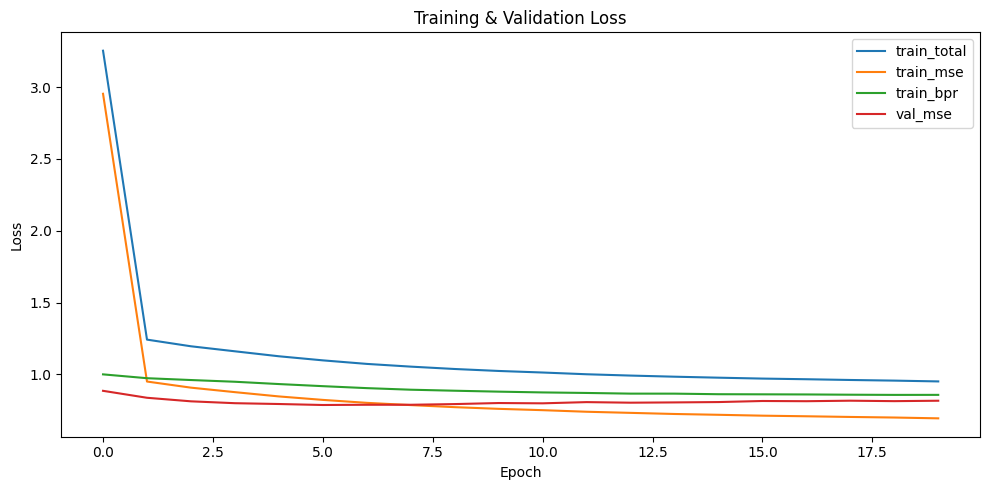

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(hist["train_total"], label="train_total")
plt.plot(hist["train_mse"],   label="train_mse")
plt.plot(hist["train_bpr"],   label="train_bpr")
plt.plot(hist["val_mse"],     label="val_mse")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()


## P) Metrics bar chart (k=5)

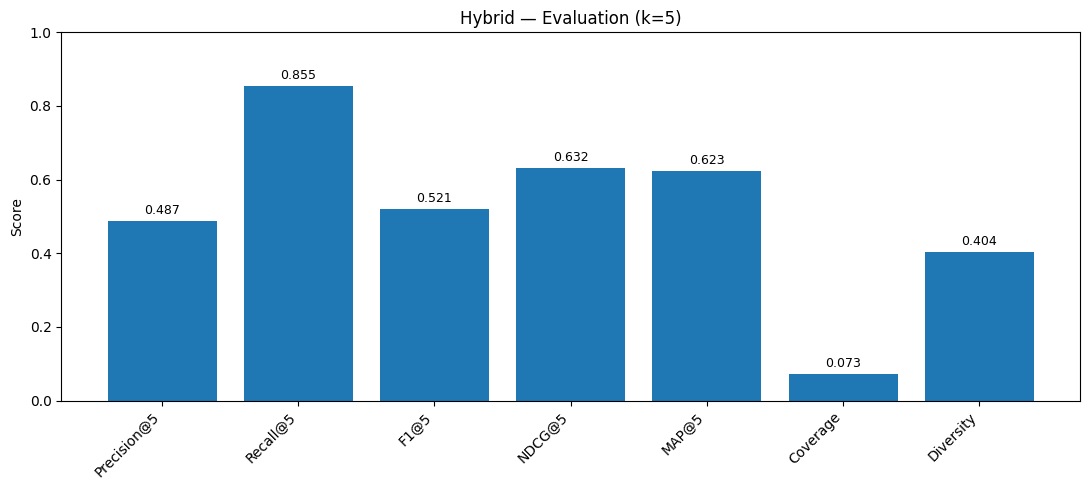

In [22]:
labels = list(metrics_k.keys())
vals   = [metrics_k[k] for k in labels]

plt.figure(figsize=(11,5))
bars = plt.bar(labels, vals)
plt.ylim(0, 1.0)
plt.title("Hybrid — Evaluation (k=5)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
for b, v in zip(bars, vals):
    plt.text(b.get_x()+b.get_width()/2, v+0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()


## Q) Predicted vs actual scatter

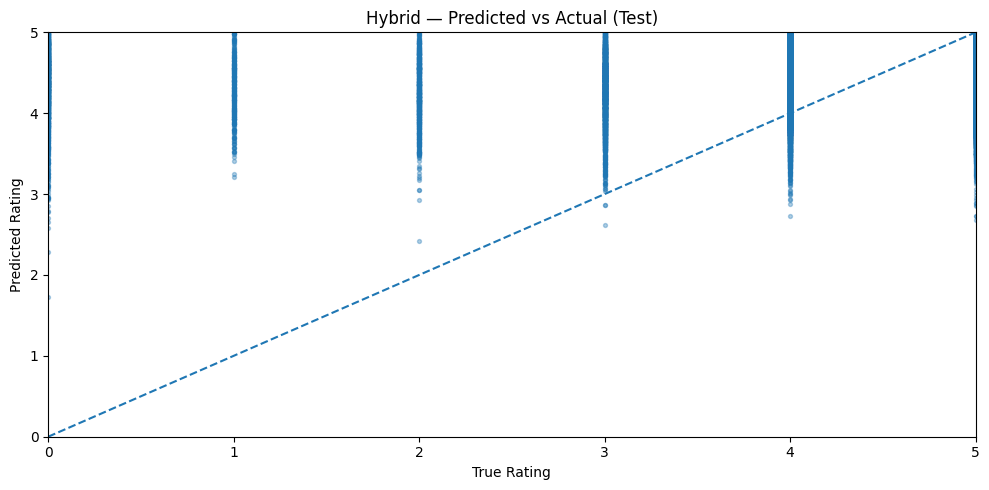

In [23]:
def collect_preds(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for u, r, X, y in loader:
            p = model(u.to(device), r.to(device), X.to(device)).cpu().numpy()
            y_true.append(y.numpy()); y_pred.append(p)
    return np.concatenate(y_true), np.concatenate(y_pred)

y_tst, p_tst = collect_preds(test_loader)

plt.figure(figsize=(10,5))
plt.scatter(y_tst, p_tst, s=8, alpha=0.35)
lims = [0, 5]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True Rating"); plt.ylabel("Predicted Rating")
plt.title("Hybrid — Predicted vs Actual (Test)")
plt.tight_layout(); plt.show()


## R) Diet ID sets

In [24]:
DIET_IDS = {
  "MEAT_IDS":   ["2445","3021","3022","3708","4020","4821","4872","6153","6206","715","7714","832"],
  "FISH_IDS":   ["1547","2657","2779","4231","4263","4270","4282","4954","4996","5704"],
  "DAIRY_IDS":  ["1838","2984","3219","3484","4836","4863","5180","5219","6324","6528","728"],
  "EGG_IDS":    ["1124","1257","1252"],
  "GLUTEN_IDS": ["63","332","335","1511","1910","2499","3497","7449","7470","7642","7284"]
}
DIET_TOGGLES = ["pescatarian","vegetarian","vegan","gluten_free","dairy_free"]


## S) Build diet_map

In [30]:
def build_diet_map_from_ids(recipes_df: pd.DataFrame) -> Dict[int, dict]:
    meat   = set(map(str, DIET_IDS["MEAT_IDS"]))
    fish   = set(map(str, DIET_IDS["FISH_IDS"]))
    dairy  = set(map(str, DIET_IDS["DAIRY_IDS"]))
    egg    = set(map(str, DIET_IDS["EGG_IDS"]))
    gluten = set(map(str, DIET_IDS["GLUTEN_IDS"]))
    dmap = {}
    for rid, ids in zip(recipes_filtered["id"].values, recipes_filtered["ingredient_ids"].values):
        ids = set(map(str, ids if isinstance(ids, (list, tuple)) else []))
        has_meat, has_fish = bool(ids & meat), bool(ids & fish)
        has_dairy, has_egg = bool(ids & dairy), bool(ids & egg)
        has_gluten = bool(ids & gluten)
        vegetarian  = not has_meat
        vegan       = vegetarian and not has_dairy and not has_egg and not has_fish
        pescatarian = not has_meat
        gluten_free = not has_gluten
        dairy_free  = not has_dairy
        dmap[int(rid)] = {"vegetarian":vegetarian, "vegan":vegan, "pescatarian":pescatarian,
                          "gluten_free":gluten_free, "dairy_free":dairy_free}
    return dmap

diet_map = build_diet_map_from_ids(recipes_filtered)
len(diet_map)


34356

## T) Phrase rules + readable names

In [31]:
from typing import List

PHRASE_RULES = [
    ("lemon juice", ["lemon","juice"]),
    ("orange juice", ["orange","juice"]),
    ("olive oil", ["olive","oil"]),
    ("plain yogurt", ["plain","yogurt"]),
    ("sour cream", ["sour","cream"]),
    ("cream cheese", ["cream","cheese"]),
    ("brown sugar", ["brown","sugar"]),
    ("baking soda", ["baking","soda"]),
    ("baking powder", ["baking","powder"]),
    ("soy sauce", ["soy","sauce"]),
    ("black pepper", ["black","pepper"]),
    ("kosher salt", ["kosher","salt"]),
]

def normalize_tokens(tokens: List[str]) -> List[str]:
    tokens = [t.lower() for t in tokens]
    used = [False]*len(tokens); out=[]
    for phrase, parts in PHRASE_RULES:
        L=len(parts); i=0
        while i<=len(tokens)-L:
            if not any(used[i:i+L]) and tokens[i:i+L]==parts:
                out.append(phrase);
                for j in range(L): used[i+j]=True
                i+=L
            else:
                i+=1
    for i,t in enumerate(tokens):
        if not used[i]: out.append(t)
    seen=set(); res=[]
    for w in out:
        if w not in seen:
            seen.add(w); res.append(w)
    return res

id_to_title, id_to_ingredients = {}, {}
if raw_recipes is not None and {"id","ingredients","name"}.issubset(raw_recipes.columns):
    rr = raw_recipes.copy()
    rr["ingredients"] = rr["ingredients"].apply(_safe_lit)
    keep = set(final_recipes)
    for rid, name, ings in zip(rr["id"], rr["name"], rr["ingredients"]):
        if int(rid) in keep:
            id_to_title[int(rid)] = str(name)
            toks = [str(x).lower() for x in (ings if isinstance(ings,(list,tuple)) else [])]
            id_to_ingredients[int(rid)] = normalize_tokens(toks)
else:
    for rid, toks in zip(recipes_filtered["id"], recipes_filtered["ingredient_tokens"]):
        id_to_title[int(rid)] = f"recipe {int(rid)}"
        flat = []
        if isinstance(toks, list):
            for g in toks:
                flat.extend(g if isinstance(g, list) else [g])
        id_to_ingredients[int(rid)] = normalize_tokens([str(t).lower() for t in flat])

len(id_to_title), len(id_to_ingredients)


(34356, 34356)

## U) Model scorers for UI

In [32]:
# Simple user content profiles for cosine scoring + hybrid utilities
user_profiles = {}
dim = content_matrix.shape[1]
ux = defaultdict(list)
for u, r in zip(train_df['user_idx'].values, train_df['recipe_idx'].values):
    ux[int(u)].append(int(r))
for u, items in ux.items():
    v = content_matrix[np.array(items)].mean(axis=0) if items else np.zeros((dim,), dtype=np.float32)
    v = v / (np.linalg.norm(v) + 1e-9)
    user_profiles[u] = v.astype(np.float32)

def _norm(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a, dtype=np.float32)
    if a.size == 0:
        return a
    mn, mx = float(a.min()), float(a.max())
    return (a - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(a, dtype=np.float32)

@torch.no_grad()
def cf_scores_for(user_idx: int, cand_ridx: np.ndarray, batch=4096) -> np.ndarray:
    cand_ridx = np.asarray(cand_ridx, dtype=np.int64)
    # Cold-start/user-out-of-range guard
    if int(user_idx) < 0 or int(user_idx) >= model.user_embed.num_embeddings:
        return np.zeros((cand_ridx.shape[0],), dtype=np.float32)
    out = np.empty(cand_ridx.shape[0], dtype=np.float32)
    for s in range(0, len(cand_ridx), batch):
        chunk = cand_ridx[s:s+batch]
        u = torch.full((len(chunk),), int(user_idx), dtype=torch.long, device=device)
        r = torch.tensor(chunk, dtype=torch.long, device=device)
        X = torch.tensor(content_matrix[chunk], dtype=torch.float32, device=device)
        p = model(u, r, X).reshape(-1).detach().cpu().numpy().astype(np.float32)
        out[s:s+len(chunk)] = p
    return out

def cbf_scores_for(user_idx: int, cand_ridx: np.ndarray) -> np.ndarray:
    prof = user_profiles.get(int(user_idx))
    if prof is None:
        return np.zeros((len(cand_ridx),), dtype=np.float32)
    X  = content_matrix[np.asarray(cand_ridx, dtype=np.int64)]
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    return (Xn @ prof).astype(np.float32)

def _pop_norm(cand_ridx: np.ndarray) -> np.ndarray:
    try:
        arr = np.array([recipe_counts.get(int(final_recipes[int(i)]), 0) for i in cand_ridx], dtype=np.float32)
        return _norm(arr)
    except Exception:
        return np.zeros((len(cand_ridx),), dtype=np.float32)

def fuse(cf: np.ndarray, cbf: np.ndarray, cand_ridx: np.ndarray, alpha=0.65, beta=0.10, gamma=0.0) -> np.ndarray:
    cf = _norm(cf); cbf = _norm(cbf)
    n = cf.shape[0]
    if n == 0:
        return cf
    order = np.argsort(-cf)
    rank = np.empty_like(order); rank[order] = np.arange(n)
    rank_pen = (rank / max(1, n-1)).astype(np.float32)
    pop_pen  = _pop_norm(np.asarray(cand_ridx, dtype=np.int64)) if gamma > 0 else 0.0
    return (alpha*cf + (1-alpha)*cbf - beta*rank_pen - gamma*pop_pen).astype(np.float32)

def mmr_rerank(cand_ridx: np.ndarray, scores: np.ndarray, k: int = 5, lambda_div: float = 0.3) -> np.ndarray:
    X = content_matrix[np.asarray(cand_ridx, dtype=np.int64)]
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    sim = (Xn @ Xn.T).astype(np.float32)
    chosen = []
    remaining = list(np.argsort(-scores))
    while remaining and len(chosen) < k:
        if not chosen:
            chosen.append(remaining.pop(0))
        else:
            best_idx, best_val = None, -1e9
            for idx in remaining[:256]:  # speed cap
                diversity = max(sim[idx, chosen]) if chosen else 0.0
                val = lambda_div * scores[idx] - (1 - lambda_div) * diversity
                if val > best_val:
                    best_val, best_idx = val, idx
            remaining.remove(best_idx)
            chosen.append(best_idx)
    return np.array(chosen + remaining, dtype=np.int64)


## V) UI helpers (random + pantry)

In [58]:
from typing import List
import re
import numpy as np
import random

# Ensures final_recipes is a plain list (not Series/array)
try:
    final_recipes = list(final_recipes)
except Exception:
    pass

# small utils
def _as_int(x):
    try:
        return int(x)
    except Exception:
        return int(float(str(x)))

def _rid_from_ridx(ridx):
    return _as_int(final_recipes[_as_int(ridx)])

def _normalize(seq):
    if seq is None:
        return []
    try:
        return list(normalize_tokens(seq))
    except NameError:
        return [str(s).strip().lower() for s in seq]

def _canon_key(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r'^(is[_\s-]*)', '', s)
    s = s.replace('-', ' ').replace('/', ' ')
    return re.sub(r'\s+', '_', s)

def _doc_text(rid: int) -> str:
    ings = " ".join(map(str, id_to_ingredients.get(int(rid), [])))
    title = str(id_to_title.get(int(rid), ""))
    return f"{title} {ings}".lower()

def _contains_any_text(rid: int, keywords: set, patterns=()) -> bool:
    s = _doc_text(rid)
    if any(k in s for k in keywords):
        return True
    for pat in patterns:
        if re.search(pat, s):
            return True
    return False

# keyword sets
_MEAT = {
    "beef","pork","bacon","ham","prosciutto","salami","mortadella","chorizo","pepperoni",
    "pastrami","bresaola","sausage","lamb","mutton","veal","chicken","turkey","duck"
}
# generic land-meat words that were letting brines/marinades slip through
_MEAT_GENERIC = {"meat","meats","poultry","game"}
_SEAFOOD = {
    "fish","salmon","tuna","cod","tilapia","shrimp","prawn","crab","lobster",
    "anchovy","anchovies","sardine","mackerel","clam","oyster","mussel","scallop"
}
_DAIRY = {"milk","butter","cheese","yogurt","cream","ghee"}
_EGGS  = {"egg","eggs"}
_HONEY = {"honey"}

_MEATY_PHRASES = {"beef stock","beef broth","chicken stock","chicken broth","pork stock","pork broth","lard","gelatin","gelatine","worcestershire"}
_SEAFOOD_SAUCES = {"fish sauce","oyster sauce","shrimp paste"}

_MEATY_PATTERNS = [
    r"\b(beef|chicken|pork|turkey)\s*[- ]?\s*(stock|broth|fat)\b",
]
_SEAFOOD_PATTERNS = [
    r"\b(fish|oyster)\s*sauce\b",
    r"\bshrimp\s*paste\b",
]

def _has_land_meat(rid: int) -> bool:
    return _contains_any_text(
        rid,
        _MEAT | _MEAT_GENERIC | _MEATY_PHRASES,
        _MEATY_PATTERNS
    )

def _has_any_seafood(rid: int) -> bool:
    return _contains_any_text(rid, _SEAFOOD | _SEAFOOD_SAUCES, _SEAFOOD_PATTERNS)

def _as_bool_val(v) -> bool:
    if isinstance(v, bool): return v
    if v is None: return False
    try:
        if isinstance(v, (int, float)): return bool(int(v))
        s = str(v).strip().lower()
    except Exception:
        return False
    if s in {"true","t","yes","y","1"}:  return True
    if s in {"false","f","no","n","0",""}: return False
    return False

# robust diet check
def complies(recipe_id: int, filters: List[str], exclude: List[str] = None) -> bool:
    rid = _as_int(recipe_id)
    filters = [_canon_key(f) for f in (filters or [])]

    # Tags (safe booleans + canonical keys) — respected if present
    tags_raw = diet_map.get(rid, {}) or {}
    tags = { _canon_key(k): _as_bool_val(v) for k, v in dict(tags_raw).items() }

    # Tag requirements (only if present)
    for key in {"vegetarian","vegan","pescatarian","gluten_free","dairy_free"} & set(filters):
        if key in tags and not tags[key]:
            return False

    # Ingredient/title guardrails
    if "vegetarian" in filters:
        if _has_land_meat(rid) or _has_any_seafood(rid):
            return False
    if "vegan" in filters:
        if _has_land_meat(rid) or _has_any_seafood(rid) or _contains_any_text(rid, _DAIRY | _EGGS | _HONEY):
            return False
    if "pescatarian" in filters:
        # seafood allowed; block any land-meat (incl. generic "meats"/"poultry", brines, broths)
        if _has_land_meat(rid):
            return False
    if "gluten_free" in filters:
        s = _doc_text(rid)
        if any(w in s for w in ["wheat","barley","rye","semolina","spelt","farro","bulgur"]):
            if not tags.get("gluten_free", False):
                return False
    if "dairy_free" in filters:
        if _contains_any_text(rid, _DAIRY) and not tags.get("dairy_free", False):
            return False

    # Explicit ingredient exclusions
    if exclude:
        ex = {str(e).strip().lower() for e in exclude if str(e).strip()}
        if any(k in _doc_text(rid) for k in ex):
            return False

    return True

def _strong_diet_prefilter(rid: int, filters: List[str]) -> bool:
    f = set(_canon_key(x) for x in (filters or []))
    if "vegan" in f:
        if _has_land_meat(rid) or _has_any_seafood(rid) or _contains_any_text(rid, _DAIRY | _EGGS | _HONEY):
            return False
    if "vegetarian" in f:
        if _has_land_meat(rid) or _has_any_seafood(rid):
            return False
    if "pescatarian" in f:
        if _has_land_meat(rid):
            return False
    if "dairy_free" in f and _contains_any_text(rid, _DAIRY):
        return False
    if "gluten_free" in f:
        s = _doc_text(rid)
        if any(w in s for w in ["wheat","barley","rye","semolina","spelt","farro","bulgur"]):
            return False
    return True

# ranking helpers
def model_pick_random(active_filters=None, k=1, exclude=None, use_mmr: bool = False,
                      alpha=0.65, beta=0.10, gamma=0.0):
    active_filters = active_filters or []

    # Candidate set (apply BOTH complies and strong text guard)
    ridxs = [
        i for i, rid in enumerate(final_recipes)
        if complies(rid, active_filters, exclude) and _strong_diet_prefilter(rid, active_filters)
    ]
    if not ridxs:
        return None if k == 1 else []
    ridxs = np.asarray(ridxs, dtype=np.int64)

    if not user_profiles:
        return None if k == 1 else []
    u = random.choice(list(user_profiles.keys()))

    cf  = cf_scores_for(u, ridxs)
    cbf = cbf_scores_for(u, ridxs)
    fin = fuse(cf, cbf, ridxs, alpha=alpha, beta=beta, gamma=gamma)

    order = mmr_rerank(ridxs, fin, k=k) if use_mmr else np.argsort(-fin)

    if k == 1:
        if len(order) == 0:
            return None
        idx = int(order[0])
        rid = _rid_from_ridx(ridxs[idx])
        return {
            "recipe_id": int(rid),
            "title": id_to_title.get(int(rid), f"recipe {int(rid)}"),
            "ingredients": id_to_ingredients.get(int(rid), []),
            "score": float(fin[idx]),
        }

    top = []
    for idx in map(_as_int, order[:k]):
        rid = _rid_from_ridx(ridxs[idx])
        top.append({
            "recipe_id": int(rid),
            "title": id_to_title.get(int(rid), f"recipe {int(rid)}"),
            "ingredients": id_to_ingredients.get(int(rid), []),
            "score": float(fin[idx]),
        })
    return top

def model_pantry_recommend(pantry_text: str, active_filters=None, k=5, exclude=None,
                           use_mmr: bool = False, alpha=0.65, beta=0.10, gamma=0.0):
    active_filters = active_filters or []

    # Normalize pantry terms
    raw = [x.strip().strip('"').strip("'") for x in (pantry_text or "").split(",") if x.strip()]
    pantry = set(_normalize(raw))

    # Candidate set (diet/exclusion + strong text guard, to block “meats/brine” etc.)
    ridxs = [
        i for i, rid in enumerate(final_recipes)
        if complies(rid, active_filters, exclude) and _strong_diet_prefilter(rid, active_filters)
    ]
    if not ridxs:
        return []
    ridxs = np.asarray(ridxs, dtype=np.int64)

    if not user_profiles:
        return []
    u = random.choice(list(user_profiles.keys()))

    # Hybrid scores (model still does the heavy lifting)
    cf  = cf_scores_for(u, ridxs)
    cbf = cbf_scores_for(u, ridxs)
    fin = fuse(cf, cbf, ridxs, alpha=alpha, beta=beta, gamma=gamma)

    order = mmr_rerank(ridxs, fin, k=k) if use_mmr else np.argsort(-fin)

    # Build output (require pantry overlap)
    out = []
    for idx in map(_as_int, order[:min(2000, len(order))]):
        rid = _rid_from_ridx(ridxs[idx])
        ings_norm = _normalize(id_to_ingredients.get(rid, []))
        have = sorted(pantry & set(ings_norm))
        if not have:
            continue
        miss = [w for w in ings_norm if w not in pantry]
        out.append({
            "recipe_id": rid,
            "title": id_to_title.get(rid, f"recipe {rid}"),
            "score": float(fin[idx]),
            "matches": have,
            "missing": miss
        })
        if len(out) >= k:
            break
    return out


## W) Minimal Tk window (launch last)

In [59]:
# --- FIXED minimal Tk window (BooleanVar needs value=...) ---
import tkinter as tk
from tkinter import ttk, messagebox

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Recipe Demo (Hybrid)")
        self.geometry("780x600"); self.minsize(720,520)

        self.status = ttk.Label(self, text=f"Model ready • users={len(user_profiles)} • recipes={len(final_recipes)}", anchor="w")
        self.status.pack(side=tk.TOP, fill=tk.X, padx=10, pady=(10,0))

        tabs = ttk.Notebook(self); tabs.pack(expand=1, fill=tk.BOTH, padx=10, pady=10)

        # Random
        t1 = ttk.Frame(tabs); tabs.add(t1, text="Random Recipe")
        ttk.Label(t1, text="Model-ranked random pick (optional dietary filters):").pack(anchor="w", padx=10, pady=(10,6))
        # BooleanVar(value=False) instead of BooleanVar(False)
        self.vars1 = {n: tk.BooleanVar(value=False) for n in DIET_TOGGLES}
        row1 = ttk.Frame(t1); row1.pack(anchor="w", padx=10, pady=(0,8))
        for n,v in self.vars1.items():
            ttk.Checkbutton(row1, text=n.replace("_"," ").title(), variable=v).pack(side=tk.LEFT, padx=(0,10))
        ttk.Button(t1, text="Get Random Recipe", command=self.on_random).pack(anchor="w", padx=10, pady=(0,8))
        self.out1 = tk.Text(t1, height=18); self.out1.pack(fill=tk.BOTH, expand=True, padx=10, pady=(0,10))

        # Pantry
        t2 = ttk.Frame(tabs); tabs.add(t2, text="Pantry Recommender")
        ttk.Label(t2, text="Enter pantry items (names, comma-separated):").pack(anchor="w", padx=10, pady=(10,4))
        self.pantry_entry = ttk.Entry(t2); self.pantry_entry.insert(0, "garlic, olive oil, lemon juice")
        self.pantry_entry.pack(fill=tk.X, padx=10)
        # BooleanVar(value=False) instead of BooleanVar(False)
        self.vars2 = {n: tk.BooleanVar(value=False) for n in DIET_TOGGLES}
        row2 = ttk.Frame(t2); row2.pack(anchor="w", padx=10, pady=(6,6))
        for n,v in self.vars2.items():
            ttk.Checkbutton(row2, text=n.replace("_"," ").title(), variable=v).pack(side=tk.LEFT, padx=(0,10))
        cnt = ttk.Frame(t2); cnt.pack(anchor="w", padx=10, pady=(0,8))
        ttk.Label(cnt, text="How many?").pack(side=tk.LEFT)
        self.k_spin = tk.Spinbox(cnt, from_=1, to=20, width=5)
        self.k_spin.delete(0, tk.END); self.k_spin.insert(0, "5")
        self.k_spin.pack(side=tk.LEFT, padx=(8,0))
        ttk.Button(t2, text="Recommend", command=self.on_pantry).pack(anchor="w", padx=10, pady=(0,8))
        self.out2 = tk.Text(t2, height=18); self.out2.pack(fill=tk.BOTH, expand=True, padx=10, pady=(0,10))

    def _filters(self, vd):
        return [k for k,v in vd.items() if v.get()]

    def on_random(self):
        try:
            f = self._filters(self.vars1)
            rec = model_pick_random(f)
            self.out1.delete("1.0", tk.END)
            if not rec:
                self.out1.insert(tk.END, "No compliant recipe found.\n"); return
            self.out1.insert(tk.END, "Model Pick\n")
            self.out1.insert(tk.END, f"Title: {rec['title']}\nID: {rec['recipe_id']}\nScore: {rec['score']:.3f}\nIngredients:\n")
            for w in rec["ingredients"]:
                self.out1.insert(tk.END, f"  • {w}\n")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def on_pantry(self):
        try:
            f = self._filters(self.vars2)
            k = int(self.k_spin.get() or 5)
            text = self.pantry_entry.get()
            ranked = model_pantry_recommend(text, f, k)
            self.out2.delete("1.0", tk.END)
            if not ranked:
                self.out2.insert(tk.END, "No matches found for the given pantry/filters.\n"); return
            self.out2.insert(tk.END, "Pantry Recommendations\n")
            for i,it in enumerate(ranked,1):
                self.out2.insert(tk.END, f"{i}. {it['title']} (ID: {it['recipe_id']})  |  Score: {it['score']:.3f}\n")
                if it["matches"]:
                    self.out2.insert(tk.END, f"   matches -> {', '.join(it['matches'])}\n")
                if it["missing"]:
                    self.out2.insert(tk.END, "   Ingredients missing:\n")
                    for w in it["missing"][:12]:
                        self.out2.insert(tk.END, f"     • {w}\n")
        except Exception as e:
            messagebox.showerror("Error", str(e))

def main():
    app = App(); app.mainloop()

main()  # run when ready
